In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models

#from imutils import paths
from pathlib import Path
import os, sys
import time
import copy

import pandas as pd
import matplotlib.pylab as plt
import numpy as np

from itertools import product
from PIL import Image

from lucent.optvis import render, param, transform, objectives
from lucent.modelzoo.util import get_model_layers
from lucent.misc.io import show
from lucent.misc.channel_reducer import ChannelReducer
from lucent.misc.io import show

from captum.insights import AttributionVisualizer, Batch
from captum.insights.features import ImageFeature
from captum.attr import IntegratedGradients, GuidedGradCam
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

# Local modules
from cub_tools.train import train_model
from cub_tools.visualize import imshow, visualize_model
from cub_tools.utils import unpickle, save_pickle
from cub_tools.transforms import makeAggresiveTransforms, makeDefaultTransforms, resizeCropTransforms

/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.decomposition.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# Script runtime options
model = 'resnet152'
root_dir = '..'
data_root_dir = os.path.join(root_dir, 'data')
model_root_dir = os.path.join(root_dir, 'models')
stages = ['test']


# Paths setup
data_dir = os.path.join(data_root_dir,'images')
output_dir = os.path.join(model_root_dir,'classification/{}'.format(model))
model_history = os.path.join(output_dir,'model_history.pkl')
model_file = os.path.join(output_dir, 'caltech_birds_{}_full.pth'.format(model))

In [3]:
# Get image transforms
# Get data transforms
data_transforms = makeDefaultTransforms(img_crop_size=224, img_resize=512)

# Setup data loaders with augmentation transforms
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in stages}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2, )
              for x in stages}
dataset_sizes = {x: len(image_datasets[x]) for x in stages}
class_names = image_datasets[stages[0]].classes

In [4]:
# Setup the device to run the computations
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device::', device)

Device:: cuda:0


In [5]:
# Load the best model from file
model_ = torch.load(model_file)
_ = model_.to(device).eval()

/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torchvision.models.resnet.Bottleneck' has changed. you can retrieve the original source code 

In [6]:
def imshow(img, transpose = True):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [35]:
help(imshow)

Help on function imshow in module __main__:

imshow(img, transpose=True)



In [10]:
dataiter = iter(dataloaders['test'])
images, labels = dataiter.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


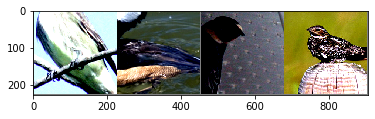

GroundTruth:  040.Olive_sided_Flycatcher 089.Hooded_Merganser 137.Cliff_Swallow 092.Nighthawk
Predicted:  102.Western_Wood_Pewee 089.Hooded_Merganser 137.Cliff_Swallow 092.Nighthawk


In [11]:
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % class_names[labels[j]] for j in range(4)))
images = images.to(device)
labels = labels.to(device)
outputs = model_(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(4)))

In [12]:
ind = 3
input = images[ind].unsqueeze(0)
input.requires_grad = True

In [13]:
def attribute_image_features(algorithm, input, label, **kwargs):
    model_.zero_grad()
    tensor_attributions = algorithm.attribute(input,
                                              target=label,
                                              **kwargs
                                             )
    
    return tensor_attributions

In [14]:
saliency = Saliency(model_)
grads = saliency.attribute(input, target=labels[ind].item())
grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (1, 2, 0))

In [15]:
ig = IntegratedGradients(model_)
attr_ig, delta = attribute_image_features(ig, input, labels[ind], baselines=input * 0, return_convergence_delta=True)
attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
print('Approximation delta: ', abs(delta))

Approximation delta:  tensor([0.4978], device='cuda:0', dtype=torch.float64)


In [ ]:
# Memory issues
#ig = IntegratedGradients(model_)
#nt = NoiseTunnel(ig)
#attr_ig_nt = attribute_image_features(nt, input, baselines=input * 0, nt_type='smoothgrad_sq',
#                                      n_samples=100, stdevs=0.2)
#attr_ig_nt = np.transpose(attr_ig_nt.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

In [20]:
dl = DeepLift(model_)
attr_dl = attribute_image_features(dl, input, labels[ind], baselines=input * 0)
attr_dl = np.transpose(attr_dl.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/captum/attr/_core/deep_lift.py:301: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  after the attribution is finished"""


RuntimeError: A Module ReLU(inplace=True) was detected that does not contain some of the input/output attributes that are required for DeepLift computations. This can occur, for example, if your module is being used more than once in the network.Please, ensure that module is being used only once in the network.

In [34]:
dir(model_.layer4.named)

['__call__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__func__',
 '__ge__',
 '__get__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__self__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__']

In [26]:
gGradCam = GuidedGradCam(model_, layer=model_.modules.)
ggCam = gGradCam.attribute(input, target=labels[ind].item())
ggCam = np.transpose(ggCam.squeeze().cpu().detach().numpy(), (1, 2, 0))

IndexError: tuple index out of range

In [16]:
fig_size=(10,10)

print('Actual: {}'.format(class_names[labels[ind]]))
print('Predicted:', class_names[predicted[ind]], 
      ' Probability:', torch.max(F.softmax(outputs, 1)).item())

original_image = np.transpose((images[ind].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))

Actual: 092.Nighthawk
Predicted: 092.Nighthawk  Probability: 0.9186034798622131


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


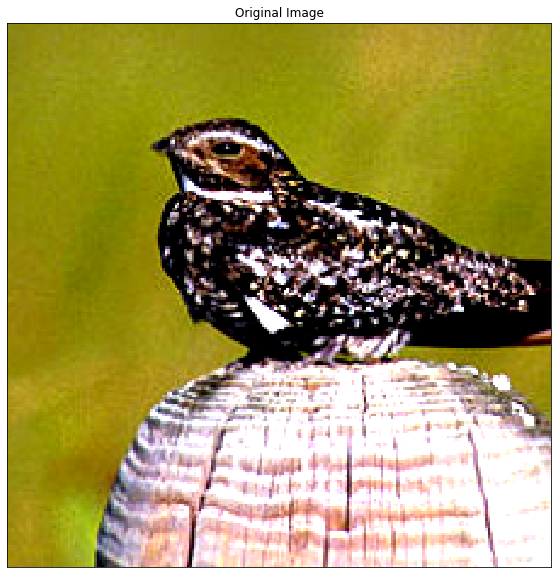

In [17]:
_ = viz.visualize_image_attr(None, original_image, fig_size=fig_size,
                      method="original_image", title="Original Image")

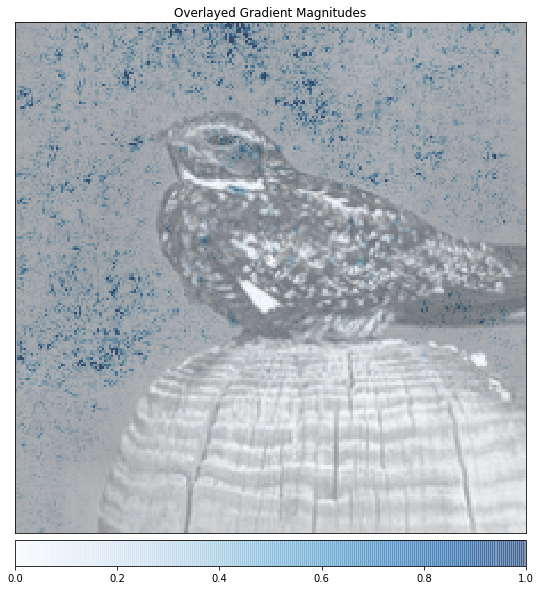

In [18]:
_ = viz.visualize_image_attr(grads, original_image, method="blended_heat_map", sign="absolute_value",
                            show_colorbar=True, title="Overlayed Gradient Magnitudes",fig_size=fig_size,)

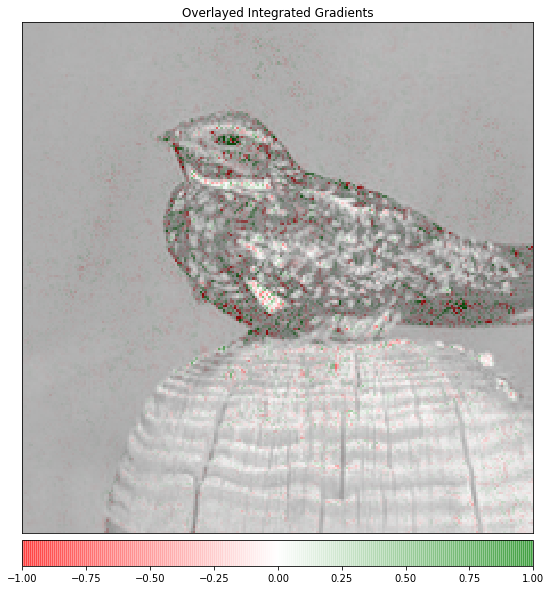

In [19]:
_ = viz.visualize_image_attr(attr_ig, original_image, method="blended_heat_map",sign="all",
                            show_colorbar=True, title="Overlayed Integrated Gradients",fig_size=fig_size,)

In [ ]:
_ = viz.visualize_image_attr(attr_dl, original_image, method="blended_heat_map",sign="all",show_colorbar=True, 
                          title="Overlayed DeepLift",fig_size=fig_size,)

In [ ]:
_ = viz.visualize_image_attr(ggCam, original_image, method="alpha_scaling",sign="absolute_value",show_colorbar=True, 
                          title="Overlayed Guide Grad Cam",fig_size=fig_size, alpha_overlay=0.5, cmap='gist_rainbow')

In [24]:
labels[ind].item()

91

In [25]:
model_

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 